# Script for processing images from aggregation-breakage measurements
### Based on Scikit image library
### Yuri Sinzato - PhD Student - University of Amsterdam
### Last version: 25-03-2023


#### Brief description of the routine:
- This routine is used to analyse raw images of aggregation-breakage of cyanobacterial colonies under a cone-and-plate shear
- Raw images are image stacks (.tif) taken with and inverted microscope mounted underneath the cone-and-plate setup
- The image stack is organized into blocks of Ns frames/block. Each block contains a set of images for a single time point. Conversion from slice number to physical time is made by function frame_time()
- The first step is pre-processing of the raw images. Two treatments are made, one to detect small colonies(or single cells) and another to detect large colonies:
    * Small colonies: Image is cropped into a smaller section, to speed the processing. The background is subtracted using a reference image. The image intensity is renormalized and then thresholded.
    * Large colonies: A gaussian blur is applied to filter small colonies. The background is subtracted using a reference image. The image intensity is renormalized and then thresholded.
- The second step is detection of features. The method skimage.measure is used to detect and measure the features.
- The third step is to count and calculate the size distribution. The large colonies are counted in the entire frame, for all frames. The total volume is assumed to be: the area of the full frame, times the height of the fluid if it lied flat on the cylindrical chamber, times the number of frams. The small calonies are counted only on the cropped frame, for all frames. For convenience, the total volume is also calculated using the full frame, even though only colonies in a cropped window are effectlively counted. The calibration constant compemsates for the cropped volume. Size distribution is defined in frequency ( number of colonies in all frames /total volume of all full frames[ml] per bin in diameter) and mass fraction ( total number of cells in coloniesin all frames /total volume of all full frames[ml] per bin in diameter). Here, the diameter is non-dimensional (divided by a single cell diameter).
- Corrections must be made to the size distribution to account for inaccuracies in the counting process, since not all colonies appear in focus in the image. The first correction is done with a reference suspension with known size distribution. A calibration function is estimated, as defined by function pos_calib ( with factor = 1). This calibration function has low precision at small sizes, due to low image resolution. A second correction is then made for small colonies: the total cell count is assumed to be constant over time, so the pos_calib is used, with the factor being modified so to conserv the total cell count. Finally, another correction function is applied to correct for sample evaporation cali_evap()
- The fourth step is calculation of the statistical descriptors (distribution median, 25th and 75th biovolume percentiles).
- In the case of a breakage measurement, the breakage rate is also calculated, being defined as the number of single cells lost by one colony per time.
- Guide on the function of the each routine cell:
    * Find features: Takes the raw-images, pre-processes them and detect the features. Needs a background image file.
    * Calculate distributions: With the detect features list (features.csv), calculates the size distribution and statistical descriptors. The final data is stored in the Data folder
    * Make background image: Takes a stack of background images (.tiff) and produces a single background file (.csv) to be used.
    * Extract frame: Use this to visualize and save single frames ( processed or not ). Needs a background image
    * Calibrate threshold: Use this to defined the suitable threshold values. Needs a background image and a image stack with colonies
    * Calibrate concentrations: Use this to estimated the first correction function for the counting. Needs a reference sample whose size distribution was characterized with a diferent equipment. 
- If you have any questions, please contact me with y.z.sinzato@uva.nl or m.jalaal@uva.nl

In [1]:
### Libraries
import math
import numpy as np
import skimage
import matplotlib.pyplot as plt
import pandas as pd
import pims
#import ipympl
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from IPython.display import clear_output



In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 9

## Functions

### 1. Functions to pre-process images 

In [398]:
### Functions to creat a background image
@pims.pipeline
def make_background(first_frame,num_frames):
    frames = pims.open(back_path)  # Choose frames for averaging
    background_image = np.average(frames[first_frame:first_frame+num_frames-1],0) # Choose frames for averaging
    background_image_float = skimage.filters.gaussian(background_image, sigma=4.0, preserve_range =True) # Gaussian Blur
    background_image = background_image_float.astype(int) # Convert back to integer array
    return background_image  # Return background image

### Function to crop image to the central part
# crop_size = width (height) of the new image in pixels
def cropper(image):
    to_crop = int(frame_width/2-crop_size/2) # Define the number of pixels to crope
    cropped_image = skimage.util.crop(image,(to_crop,to_crop)) # Crop image
    return cropped_image

In [399]:
### Function to pre-process images aiming for large colonies(subtract background, gaussian blur, and threshold)
## Subtract background: Where image is lower than background (black spot==colony), take the difference and invert (colony becomes white spot), while background becomes black
## New image is renormalized so that a 0 black spot becomes a 65535 white spot 
@pims.pipeline
def apply_threshold_large(image):
    sub_image = np.where(image < background_image, 65535.0*np.divide((background_image-image),background_image), 0*image)  # Subtract the background, renormalized and invert to white particles in black background
    filt_image_float = skimage.filters.gaussian(sub_image, sigma=blur_radius, preserve_range =True) # Gaussian Blur
    filt_image = filt_image_float.astype(int) # Convert back to integer array
    #thr_value_otsu =  skimage.filters.threshold_otsu(filt_image)  # value of threshold by Otsu method
    #print("Otsu-threshold = "+str(thr_value_otsu))
    thr_array = thr_value_large*np.ones(np.shape(filt_image)) #Initialize new array
    thr_image = 65535*np.greater(filt_image,thr_array) # Threshold image, particles are white(65535) in black background(0)
    return thr_image  # Return treated image

### Function to pre-process images aiming for small colonies(subtract background, crop, and threshold)
@pims.pipeline
def apply_threshold_small(image):
    sub_image = np.where(image < background_image, 65535.0*np.divide((background_image-image),background_image), 0*image)  # Subtract the background, renormalized and invert to white particles in black background
    filt_image_float = cropper(sub_image) # Crop image
    filt_image = filt_image_float.astype(int) # Convert back to integer array
    thr_array = thr_value_small*np.ones(np.shape(filt_image)) #Initialize new array
    thr_image = 65535*np.greater(filt_image,thr_array) # Threshold image, particles are white(65535) in black background(0)
    return thr_image  # Return treated image


In [400]:
## Same but no threshold
### Function to pre-process images aiming for large colonies(subtract background, gaussian blur, and threshold)
## Subtract background: Where image is lower than background (black spot==colony), take the difference and invert (colony becomes white spot), while background becomes black
## New image is renormalized so that a 0 black spot becomes a 65535 white spot 
@pims.pipeline
def pre_nt_large(image):
    sub_image = np.where(image < background_image, 65535.0*np.divide((background_image-image),background_image), 0*image)  # Subtract the background, renormalized and invert to white particles in black background
    filt_image_float = skimage.filters.gaussian(sub_image, sigma=blur_radius, preserve_range =True) # Gaussian Blur
    filt_image = filt_image_float.astype(int) # Convert back to integer array
    #filt_image = filt_image_float
    return filt_image  # Return treated image

## New image is renormalized so that a 0 white spot becomes a 65535 negative spot 
@pims.pipeline
def pre_nt_ni_large(image):
    sub_image = np.where(image < background_image, 65535.0*np.divide((background_image-image),background_image), 0*image)  # Subtract the background, renormalized and invert to white particles in black background
    sub_image = 65535.0*np.ones(np.shape(sub_image)) - sub_image  # Subtract the background, renormalized and invert to white particles in black background
    filt_image_float = skimage.filters.gaussian(sub_image, sigma=blur_radius, preserve_range =True) # Gaussian Blur
    filt_image = filt_image_float.astype(int) # Convert back to integer array
    #filt_image = filt_image_float
    return filt_image  # Return treated image


### Function to pre-process images aiming for small colonies(subtract background, crop, and threshold)
@pims.pipeline
def pre_nt_small(image):
    sub_image = np.where(image < background_image, 65535.0*np.divide((background_image-image),background_image), 0*image)  # Subtract the background, renormalized and invert to white particles in black background
    filt_image_float = cropper(sub_image) # Crop image
    filt_image = filt_image_float.astype(int) # Convert back to integer array
    #filt_image = filt_image_float
    return filt_image  # Return treated image

### 2. Funtions for calibrations

In [ ]:
### Function to calibrate background
def calib_back():
    while True:
        fig = plt.figure(num=1,figsize=[15,15])
        ax1=fig.add_subplot(4,2,1)
        axcount_high=fig.add_subplot(4,2,2)
        aratio_high=fig.add_subplot(4,2,3)
        acone_low=fig.add_subplot(4,2,4)
        axcount_low=fig.add_subplot(4,2,5)
        axratio_low=fig.add_subplot(4,2,6)
        ax7=fig.add_subplot(4,2,7)
        ax8=fig.add_subplot(4,2,8)
        ax7.set_yscale("log")
        ax8.set_yscale("log")
        treated_frame_large = apply_threshold_large(pims.open(cali_path))
        treated_frame_small = apply_threshold_small(pims.open(cali_path))
        A_aver = 0.0
        total_lab = 0   
        for num in range(num_img_to_cal):
            clear_output()
            print("Current frame being measured: " + str(num))
            label_image_l, n_of_labels_in_l = skimage.measure.label(treated_frame_large[num], return_num=True)
            label_image_s, n_of_labels_in_s = skimage.measure.label(treated_frame_small[num], return_num=True)
            for region in skimage.measure.regionprops(label_image_s, intensity_image=treated_frame_small[num]):
                # Average cell area in cropped image (Assuming the cells diameter are within 0.5*d1 and 2*d1)
                if (2*(region.area)**0.5/math.pi < 2*d1/pixel_size and 2*(region.area)**0.5/math.pi > 0.5*d1/pixel_size):
                    A_aver += pixel_size**2*region.area
                    total_lab+=1
        A_aver=A_aver/total_lab
        # Large frame
        ax1.imshow(basic_image[frame_to_show-1], cmap='gray')
        aratio_high.imshow(treated_frame_large[frame_to_show-1], cmap='gray')
        axcount_low.imshow(pre_nt_large(basic_image[frame_to_show-1]), cmap='gray')
        ax7.hist(pre_nt_large(basic_image[frame_to_show-1]).flatten(),70000,(0,70000))
        # Small frame
        axcount_high.imshow(cropper(basic_image[frame_to_show-1]), cmap='gray')
        acone_low.imshow(treated_frame_small[frame_to_show-1], cmap='gray')
        axratio_low.imshow(pre_nt_small(basic_image[frame_to_show-1]), cmap='gray')
        ax8.hist(pre_nt_small(basic_image[frame_to_show-1]).flatten(),70000,(0,70000))
        plt.show()
        print('Large threshold calibrated to ' +str(thr_value_large))
        print('Number of features detected: ' +str(n_of_labels_in_l))
        print('Small threshold calibrated to ' +str(thr_value_small))
        print('Average feature area: ' +str(A_aver) + ' um2')
        good_ans = input('Is threshold good? [y] or [n]')
        if good_ans =='y':
            break
        thr_value_large = int(input('New large threshold:'))
        thr_value_small = int(input('New small threshold:'))
        clear_output()
    
    print('Large threshold calibrated to ' +str(thr_value_large))
    print('Small threshold calibrated to ' +str(thr_value_small))

    return (thr_value_large,thr_value_small) 

In [ ]:
### Function to calculate reference distributions
def calc_ref_dist():
    # Bins
    r_bin = np.zeros(N_br)  # Bins center particle size distribution
    for i_bin_r in range(N_br):
        r_bin[i_bin_r] = (i_bin_r + 0.5) * h_br  # Bin center    

    # Read csv file with particle information for cone-and-plate
    psd = pd.read_csv(fea_cone_path)
    slice = np.zeros(len(psd))
    slice = psd['frame']
    feret = np.zeros(len(psd))
    feret = psd['dferet']
    p_dia = feret / d1  # non-dimensional diameter
    # Combining frames to improve averages
    frame_max = int(max(slice)+1)  # Total number of slices
    # Loop over frames
    bin_r = np.zeros(N_br)  # Bins for particle size distribution weigted by frequency
    for i_p in range(len(psd)):
        # Bin
        i_bin_r = min(math.floor(p_dia[i_p] / h_br), N_br - 1)
        bin_r[i_bin_r] += 1.0
        
    # Calculate relative uncertainty due to cell counting - 1/sqrt(N)
    unc_bin_r_cone = np.ones(N_br)/np.sqrt(np.maximum(bin_r,np.ones(N_br)))
    # Convert to concentration 
    # ( for large colonies > cut_off_size : number of colonies in all full frames/total volume of all full frames[ml] per bin in diameter)
    # ( for small colonies < cut_off_size : number of colonies in all cropped frames/total volume of all full frames[ml] per bin in diameter)
    bin_r = bin_r/frame_max/frame_vol_4x/h_br
    
    bin_r_cone = bin_r

    
    # Read csv file with particle information for Nikon T2 - 4x . Low magnification was used to measure large colonies : cut-off-size
    psd = pd.read_csv(fea_Ti2_4x_path)
    slice = np.zeros(len(psd))
    slice = psd['Slice']
    feret = np.zeros(len(psd))
    feret = psd['Feret']
    p_dia = feret / d1  # non-dimensional diameter
    # Combining frames to improve averages
    frame_max = int(max(slice)+1)  # Total number of slices
    # Loop over frames
    bin_r = np.zeros(N_br)  # Bins for particle size distribution
    for i_p in range(len(psd)):
        # Bin
        i_bin_r = min(math.floor(p_dia[i_p] / h_br), N_br - 1)
        bin_r[i_bin_r] += 1.0
    # Calculate relative uncertainty due to cell counting - 1/sqrt(N)
    unc_bin_r_nikon_4x = np.ones(N_br)/np.sqrt(np.maximum(bin_r,np.ones(N_br)))
    # Convert to concentration (Number of colonies in all full frames/total volume of all full frames[ml] per bin in diameter)
    bin_r = bin_r/frame_max/frame_vol_4x/h_br
    
    bin_r_nikon_4x = bin_r

    # Read csv file with particle information for Nikon T2 - 10x - High magnification was used to measure single cells and small colonies < cut-off size
    psd = pd.read_csv(fea_Ti2_10x_path)
    slice = np.zeros(len(psd))
    slice = psd['Slice']
    feret = np.zeros(len(psd))
    feret = psd['Feret']
    p_dia = feret / d1  # non-dimensional diameter
    # Combining frames to improve averages
    frame_max = int(max(slice)+1)  # Total number of slices
    # Loop over frames
    bin_r = np.zeros(N_br)  # Bins for particle size distribution
    for i_p in range(len(psd)):
        # Bin
        i_bin_r = min(math.floor(p_dia[i_p] / h_br), N_br - 1)
        bin_r[i_bin_r] += 1.0
    # Calculate relative uncertainty due to cell counting - 1/sqrt(N)
    unc_bin_r_nikon_10x = np.ones(N_br)/np.sqrt(np.maximum(bin_r,np.ones(N_br)))
    # Convert to concentration (Number of colonies in all full frames/total volume of all full frames[ml] per bin in diameter)
    bin_r = bin_r/frame_max/frame_vol_10x/h_br
    
    bin_r_nikon_10x = bin_r
    
    
    # Calculate ratios
    bin_r_ratio = np.zeros(N_br)
    # Calibratrion constant small
    cons_cali_small = 0
    i_small = 0
    cons_cali_large = 0
    i_large = 0
    for i_bin_r in range(N_br):
        if r_bin[i_bin_r] < 0.5:   # Colonies smaller than half cell diameter are ignored, as these are artifacts smaller than a cell
            bin_r_ratio[i_bin_r] = 1 # Ti2 over cone and palte
        elif r_bin[i_bin_r] < 2.0: # Colonies smaller than 2 cell diameters have a low precision in the size measurement.  
            if bin_r_cone[i_bin_r] >0:
                bin_r_ratio[i_bin_r] = bin_r_nikon_10x[i_bin_r]/bin_r_cone[i_bin_r] # Ti2 over cone and palte
                i_small += 1
                cons_cali_small += bin_r_ratio[i_bin_r]
            else:
                bin_r_ratio[i_bin_r] = 1e12
        elif r_bin[i_bin_r] >= cut_off_size: # Colonies larger than the cut-off size have a good precision. Their number is small enough to be counted over the entire frames. Colonies larger than 25 are not suitable for calibration due to their low numbers
            if bin_r_cone[i_bin_r] >0:
                bin_r_ratio[i_bin_r] = bin_r_nikon_4x[i_bin_r]/bin_r_cone[i_bin_r] # Ti2 over cone and palte
            else:
                bin_r_ratio[i_bin_r] = 1e12
            if r_bin[i_bin_r] < 25:
                i_large += 1
                cons_cali_large += bin_r_ratio[i_bin_r]            
        else: # Colonies bewteen 2 cell diamters and the cut-off size have the following properties: i) high count, therefore only a small window of the frame is required for counting, ii) Low precision on size measurement
            bin_r_ratio[i_bin_r] = bin_r_nikon_10x[i_bin_r]/bin_r_cone[i_bin_r] # Ti2 over cone and palte

    # Propagate uncertainty in colony size measurement into concentration of colonies per bin, and combine with counting uncertainty
    # Uncertainty for cone-and plate
    relative_ratio_nei_bins = 0.5*(np.absolute(bin_r_cone[:-2]- bin_r_cone[1:-1])  +  np.absolute((bin_r_cone[2:]- bin_r_cone[1:-1])))/np.maximum(bin_r_cone[1:-1],np.ones(bin_r_cone[1:-1].shape))     # Absolute relative difference between neighboring bins    
    relative_ratio_nei_bins = np.insert(np.append(relative_ratio_nei_bins,0),0,0) # Pad with zeros
    unc_bin_r_cone = np.sqrt(unc_bin_r_cone**2 + (relative_ratio_nei_bins*(pixel_size*2/d1)/r_bin)**2) # Combine uncertainties: sqrt of sum of squared uncertainties
    # Uncertainty for counting chamber. Size uncertainty is only relevant for the small colonies
    relative_ratio_nei_bins = 0.5*(np.absolute(bin_r_nikon_10x[:-2]- bin_r_nikon_10x[1:-1])  +  np.absolute((bin_r_nikon_10x[2:]- bin_r_nikon_10x[1:-1])))/np.maximum(bin_r_nikon_10x[1:-1],np.ones(bin_r_nikon_10x[1:-1].shape))     # Absolute relative difference between neighboring bins    
    relative_ratio_nei_bins = np.insert(np.append(relative_ratio_nei_bins,0),0,0)
    unc_bin_r_nikon_10x = np.sqrt(unc_bin_r_nikon_10x**2 + (relative_ratio_nei_bins*(0.4*pixel_size*2/d1)/r_bin)**2) # # Pixel size is adjusted for 10x magnification. Combine uncertainties: sqrt of sum of squared uncertainties


    # Compute calibration constants. For small colonies
    #The large colonies are counted in the entire frame, for all frames. The total volume is assumed to be: the area of the full frame, times the height of the fluid if it lied flat on the cylindrical chamber, times the number of frams. 
    #The small colonies are counted only on the cropped frame, for all frames. For convenience, the total volume is also calculated using the full frame, even though only colonies in a cropped window are effectlively counted. The calibration constant compemsates for the cropped volume.
    cons_cali_small = cons_cali_small/i_small
    cons_cali_large = cons_cali_large/i_large    
    cons_cali_cutoff = cons_cali_large*(np.average(bin_r_cone[10:13])/np.average(bin_r_cone[7:10]))    # Calibration constant close and smaller to cut-off. The calibatrion constant should give continuity over the two ranges

    # Print the rcalibration constants
    print('-> Calibration constants used in this script for colony counting: \n')
    print('Calibration constant for single cells:'+str(cons_cali_small))
    print('Calibration constant for small colonies close to cut-off:'+str(cons_cali_cutoff))
    print('Calibration constant for large colonies:'+str(cons_cali_large))

    # The more intuitive descriptions is to compute the concentration of small colonies using only the cropped volume. In the plots below, we show the calibrations constants if  only the counts were divided by the cropped volume. 
    # This is for the plots and supplementary information only, to have a more intuitive description. For this remining of this script, the costants above were used, which already incorporates the crropped volume correction. Both approaches are equivalent and lead to the same result.  
    bin_r_cone[0:int(cut_off_size/h_br)]=bin_r_cone[0:int(cut_off_size/h_br)]*(frame_width/crop_size)**2 # Apply the ratio of full frame volume by cropped frame volume
    bin_r_nikon_4x = bin_r_nikon_4x # Divide by bin width
    bin_r_nikon_10x = bin_r_nikon_10x # Divide by bin width
    bin_r_ratio[0:int(cut_off_size/h_br)]=bin_r_ratio[0:int(cut_off_size/h_br)]/(frame_width/crop_size)**2 # Apply the ratio of full frame volume by cropped frame volume
    cons_cali_small_si = cons_cali_small/(frame_width/crop_size)**2# Apply the ratio of full frame volume by cropped frame volume
    cons_cali_cutoff_si = cons_cali_cutoff/(frame_width/crop_size)**2# Apply the ratio of full frame volume by cropped frame volume
    cons_cali_large_si = cons_cali_large
    print('\n -> Calibration constants were small colony counts are divived by the cropped volume. This representation is equivalent, but it was not used in this script for colony counting: \n')
    print('Calibration constant for single cells:'+str(cons_cali_small_si))
    print('Calibration constant for small colonies close to cut-off:'+str(cons_cali_cutoff_si))
    print('Calibration constant for large colonies:'+str(cons_cali_large_si))

    # Plot size distributions
    fig, axs = plt.subplots(4, 2, figsize=[7, 8], gridspec_kw={'width_ratios': [1, 2]})
    xrange_high = [5,30]
    xrange_low = [0.5,5]
    # Higher range
    
    axcone_high=axs[0,1]
    axcone_high.set_xlim(xrange_high)
    axcone_high.set_ylim([0,50])
    axcone_high.set_xticklabels([]) # Remove x-axis numbers
    axcone_high.set_ylabel('Concentration (colonies/ml/bin)')
    axcone_high.bar(r_bin,bin_r_cone,width=h_br,yerr=bin_r_cone*unc_bin_r_cone,color = 'c',alpha=0.5,ecolor='c', label='Cone-and-plate')
    axcone_high.legend(frameon=False)

    axcount_high=axs[1,1]
    axcount_high.set_xlim(xrange_high)
    axcount_high.set_ylim([0,80])
    axcount_high.set_xticklabels([]) # Remove x-axis numbers
    axcount_high.set_ylabel('Concentration (colonies/ml/bin)')
    axcount_high.bar(r_bin,bin_r_nikon_4x,width=h_br,yerr=bin_r_nikon_4x*unc_bin_r_nikon_4x,color='g',alpha=0.5,ecolor='g', label='Counting Chamber')
    axcount_high.legend(frameon=False)

    aratio_high=axs[2,1]
    aratio_high.set_xlim(xrange_high)
    aratio_high.set_ylim([0,4])
    aratio_high.set_ylabel('Concentration ratio')
    #aratio_high.set_xlabel('Relative diameter')
    aratio_high.set_xticklabels([]) # Remove x-axis numbers
    aratio_high.bar(r_bin,bin_r_ratio,width=h_br,yerr=bin_r_ratio*(unc_bin_r_cone**2+unc_bin_r_nikon_4x**2)**0.5,color='m',alpha=0.5,ecolor='m', label='Counting chamber/ \n Cone and plate')
    aratio_high.plot(r_bin,cons_cali_large_si*np.ones(r_bin.shape),color = 'black', ls='--') # Plot calibration constant
    aratio_high.legend(frameon=False)

    

    # Lower range
    acone_low=axs[0,0]
    
    acone_low.set_xlim(xrange_low)
    acone_low.set_xticks([1,2,3,4,5]) 
    acone_low.set_ylim([0,20000])
    acone_low.set_xticklabels([]) # Remove x-axis numbers
    acone_low.set_ylabel('Concentration (colonies/ml/bin)')
    acone_low.bar(r_bin,bin_r_cone,width=h_br,yerr=bin_r_cone*unc_bin_r_cone,color = 'c',alpha=0.5,ecolor='c', label='Cone-and-plate') 

    axcount_low=axs[1,0]
    axcount_low.set_xlim(xrange_low)
    axcount_low.set_xticks([1,2,3,4,5]) 
    axcount_low.set_ylim([0,80000])
    axcount_low.set_xticklabels([]) # Remove x-axis numbers
    axcount_low.set_ylabel('Concentration (colonies/ml/bin)')
    axcount_low.bar(r_bin,bin_r_nikon_10x,width=h_br,yerr=bin_r_nikon_10x*unc_bin_r_nikon_10x,color='g',alpha=0.5,ecolor='g', label='Counting Chamber')

    axratio_low=axs[2,0]
    axratio_low.set_xlim(xrange_low)
    axratio_low.set_xticks([1,2,3,4,5]) 
    axratio_low.set_ylim([0,7])
    axratio_low.set_xticklabels([]) # Remove x-axis numbers
    axratio_low.set_ylabel('Concentration ratio')
    #axratio_low.set_xlabel('Relative diameter')
    axratio_low.bar(r_bin[1:],bin_r_ratio[1:],width=h_br,yerr=bin_r_ratio[1:]*(unc_bin_r_cone[1:]**2+unc_bin_r_nikon_10x[1:]**2)**0.5,color='m',alpha=0.5,ecolor='m', label='Ratio')
    axratio_low.plot(r_bin,cons_cali_small_si*np.ones(r_bin.shape),color = 'black', ls='--') # Plot calibration constant
    

    # Apply the corrections and calculate the normalized biovolume distributions
    # Read csv file with particle information for cone-and-plate
    psd = pd.read_csv(fea_cone_path)
    slice = np.zeros(len(psd))
    slice = psd['frame']
    feret = np.zeros(len(psd))
    feret = psd['dferet']
    p_dia = feret / d1  # non-dimensional diameter
    # Combining frames to improve averages
    frame_max = int(max(slice)+1)  # Total number of slices
    # Loop over frames
    mass_bin_r = np.zeros(N_br)  # Bins for particle size distribution weighted by mass
    for i_p in range(len(psd)):
        # Bin
        i_bin_r = min(math.floor(p_dia[i_p] / h_br), N_br - 1)
        mass_bin_r[i_bin_r] += p_dia[i_p]**df3*pos_calib(p_dia[i_p],1) # Using fractal dimension convert results to mass (number of cells in colony) and correction function to normalized
    # Normalize the distribution
    mass_bin_r = mass_bin_r/(h_br*np.sum(mass_bin_r))

    axcone_low_norm=axs[3,0]
    axcone_low_norm.set_xlim(xrange_low)
    axcone_low_norm.set_ylim([0,0.3])
    axcone_low_norm.set_xticks([1,2,3,4,5]) 
    #axcone_low_norm.set_xticklabels([]) # Remove x-axis numbers
    axcone_low_norm.set_ylabel('Biovolume distribution')
    axcone_low_norm.set_xlabel('Relative diameter')
    axcone_low_norm.bar(r_bin,mass_bin_r,width=h_br,yerr=mass_bin_r*unc_bin_r_cone,color = 'c',alpha=0.5,ecolor='c', label='Cone-and-plate') 

    axcone_high_norm=axs[3,1]
    axcone_high_norm.set_xlim(xrange_high)
    axcone_high_norm.set_ylim([0,0.05])
    #axcone_high_norm.set_xticklabels([]) # Remove x-axis numbers
    axcone_high_norm.set_ylabel('Biovolume distribution')
    axcone_high_norm.set_xlabel('Relative diameter')
    axcone_high_norm.bar(r_bin,mass_bin_r,width=h_br,yerr=mass_bin_r*unc_bin_r_cone,color = 'c',alpha=0.5,ecolor='c', label='Cone-and-plate') 
    axcone_high_norm.legend(frameon=False)


    plt.subplots_adjust(hspace=0.3, wspace=0.3) # Adjust plot scpacing
    
    plt.savefig('Figure SI - Calibration curve.pdf')
    plt.show()
    

    finished = True
    return finished

In [20]:
### Routine correct concentration
def pre_calib(d_feret):
    # First calibration - No correction for mass. Two classes calibration with smooth transition
    if d_feret < cut_off_size: # Small colonies - Calculated to provide a smooth transition thorugh the cut-off
        calibri = cons_cali_cutoff
    else:  # Large colonies - Calculated from ratio between reference concentration and measured concentration 
        calibri = cons_cali_large
    return calibri

def cor_calib(d_feret):
    # Estimate mass correction for small colonies
    if d_feret < 2:  # Single cells - Calculated from ratio between reference concentration and measured concentration 
        calibri = cons_cali_small - cons_cali_cutoff
    elif d_feret < cut_off_size-1: # Linear transition from small to large colonies
        calibri = (cons_cali_small-cons_cali_cutoff)*(cut_off_size-1.0-d_feret)/(cut_off_size-1.0-2.0)        
    elif d_feret < cut_off_size: # Close to cut-off - Calculated to provide a smooth transition thorugh the cut-off
        calibri = 0
    else:  # Large colonies - Calculated from ratio between reference concentration and measured concentration 
        calibri = 0
    return calibri

def pos_calib(d_feret,factor):
    # Second calibration - Correction for mass conservation. Two classes calibration with smooth transition
    if d_feret < 2:  # Single cells - Calculated from ratio between reference concentration and measured concentration, times a factor to correct mass 
        calibri = factor*(cons_cali_small-cons_cali_cutoff)+cons_cali_cutoff
    elif d_feret < cut_off_size-1: # Linear transition from small to large colonies , times a factor to correct mass
        calibri = cons_cali_cutoff + factor*(cons_cali_small-cons_cali_cutoff)*(cut_off_size-1.0-d_feret)/(cut_off_size-1.0-2.0)        
    elif d_feret < cut_off_size: # Close to cut-off - Calculated to provide a smooth transition thorugh the cut-off
        calibri = cons_cali_cutoff
    else:  # Large colonies - Calculated from ratio between reference concentration and measured concentration 
        calibri = cons_cali_large
    return calibri

### 3. Function to convert time

In [404]:
### Function to calculate frame time in minutes based on frame number
def frame_time(frame_num):
    cycle = math.floor(frame_num/Ns) # Measuring cycle
    if cycle<12:
        time_sec = cycle*300
    elif cycle<24:
        time_sec = 12*300 + (cycle-12)*1200
    else:
        time_sec = 12*300 + 12*1200 + (cycle-24)*7200
    return time_sec # Return time in sec


In [405]:
### Function to correct concentration due to evaporation
def cali_evap(time):   # time in seconds
    a_evap = -5.6419e-6 # Rate of loss of mass - Calibrated on 7-2-23
    cali_evap = 1 + a_evap*time  # Constant to multiply by the measured concentration
    return cali_evap

### 4. Function to detect features

In [406]:
### Function to import frames and find features, which are stored into a csv file
# Input is the folder path for the frame images and frame range to use
# Output is the last frame
# Images are treated in two separate parts: The full frame is used to detect large features( > cut-off diameter), and a cropped frame is used to detected small features
def import_frames(frame_path,limit_frame):
    # Import frames
    frames = apply_threshold_large(pims.open(frame_path)) # Apply threshold on full frames
    frames_small = apply_threshold_small(pims.open(frame_path)) # Apply threshold on croppped frames
    # Label Features
    label_image, number_of_labels = skimage.measure.label(frames[len(frames) - 1], return_num=True) # Identify features in frames
    print("Found %d features" % (number_of_labels))

    # Measure features properties
    features = pd.DataFrame()  # Initialize features dataframe
    i_df = 0  # Index for filtered feature among all frames
    for num, img in enumerate(frames ):
        clear_output()
        if num >= limit_frame:   # Stop analysis at a specific frame. Only for debugging
            break
        print("Current frame being measured: " + str(num))
        label_image = skimage.measure.label(img)  # Label features
        label_image_small = skimage.measure.label(frames_small[num]) # Label features

        #Large features - Equivalent diameter larger than a cut-off diameter
        for region in skimage.measure.regionprops(label_image, intensity_image=img):
            # Store features
            if (pixel_size*region.feret_diameter_max/d1 >= cut_off_size and region.eccentricity < 0.9):
                newline = pd.DataFrame({'frame': num,
                                        'A': pixel_size**2*region.area,
                                        'dferet': pixel_size*region.feret_diameter_max,
                                        'rg': pixel_size*math.sqrt(
                                            (region.moments_central[2, 0] + region.moments_central[0, 2]) / region.area),
                                        'theta': region.orientation,
                                        'ecc': region.eccentricity,
                                        }, index=[i_df], )
                features = pd.concat([features, newline], axis=0)
                i_df += 1

        #Small features - Equivalent diameter smaller than a cut-off diameter, but larger then a 0.5*d1 particle
        for region in skimage.measure.regionprops(label_image_small, intensity_image=frames_small[num]):
            # Store features
            if (pixel_size*region.feret_diameter_max/d1 < cut_off_size and pixel_size*region.feret_diameter_max/d1 > 0.5):
                newline = pd.DataFrame({'frame': num,
                                        'A': pixel_size**2*region.area,
                                        'dferet': pixel_size*region.feret_diameter_max,
                                        'rg': pixel_size*math.sqrt(
                                            (region.moments_central[2, 0] + region.moments_central[0, 2]) / region.area),
                                        'theta': region.orientation,
                                        'ecc': region.eccentricity,
                                        }, index=[i_df], )
                features = pd.concat([features, newline], axis=0)
                i_df += 1
    
    print(features)
    features.to_csv('Temporary Results/features.csv')
    return img


### 5. Functions to calculate distributions

In [407]:
### Function to median and percentiles given an array of mass distribution
def find_r_per(mass_bin,r_bin,perc):
    # mass_bin is the array of mass fraction by size for fized time 
    # r_bin is the bin centers
    # perc is the percentile to find (0 is the origin, 1 is infinity)
    mass_bin = mass_bin + 1e-7*np.ones(N_br) # Make the function increasing
    mass_bin = mass_bin/np.sum(mass_bin) # Normalize
    cum_bin = np.cumsum(mass_bin) # Cumulative sum
    r_perc = np.interp(perc,cum_bin, r_bin) +0.5*h_br # Find percentile
    return r_perc

In [408]:
### Function to calculate colony size (mass) distributions
## bin_r (r_j) = Number of colonies with size in a bin h_r(r-0.5h_r:r+0.5h_r) per volume(ml) -> bin_r(r) * h_r [number of colonies/ml] 
def calculate_distributions():
    # Read csv file with particle information
    psd = pd.read_csv('Temporary Results/features.csv')
    area = np.zeros(len(psd))
    area = psd['A']
    slice = np.zeros(len(psd))
    slice = psd['frame']
    feret = np.zeros(len(psd))
    feret = psd['dferet']
    p_dia = feret / d1  # non-dimensional diameter
    p_area = area / a1  # non=dimensional projected area
    p_vol = (p_area) ** 1.5  # non-dimensional max volume(based on equivalent circulat area)
    p_df2 = np.zeros(len(psd))  #2D fractal dimension
    p_df3 = np.zeros(len(psd))  #3D fractal dimension
    p_mass = np.zeros(len(psd))  # non-dimensional mass.
    for i in range(len(psd)):
        p_df2[i] = math.log(p_area[i]) / math.log(p_dia[i])  # 2D-Fractal dimension
        p_df3[i] = df3
        #p_df3[i] = 1.391 + 0.01 * np.exp(2.164 * p_df2[
        #    i])  # Estimate of 3D-FD based on empirical correlation by Lee (2004) Prediction of three ...
        p_mass[i] = p_dia[i] ** p_df3[i]

    # Combining frames to improve averages
    frame_max = int(max(slice)+1)  # Total number of slices
    time_p_num = math.ceil(frame_max / Ns)  # Total number of frame blocks
    time_p = np.zeros(time_p_num)
    # Bins
    r_bin = np.zeros(N_br)  # Bins center particle size distribution
    bin_r = np.zeros((N_br, time_p_num))  # Bins for particle size distribution
    mass_bin_r = np.zeros((N_br, time_p_num))  # Mass of Bins for particle size distribution
    mass_bin_r_s = np.zeros((N_br, time_p_num))  # Mass of Bins for particle size distribution - only small col
    mass_bin_r_l = np.zeros((N_br, time_p_num))  # Mass of Bins for particle size distribution - only large col
    for i_bin_r in range(N_br):
        r_bin[i_bin_r] = (i_bin_r + 0.5) * h_br  # Bin center
        
    # Initialize statistics
    col_con = np.zeros(time_p_num)  # Initializing the colony concentration per ml
    cell_con = np.zeros(time_p_num)  # Initializing the cell concentration per ml
    corr_mass = np.zeros(time_p_num)  # Initializing the corrections mass for calibration function
    corr_fac = np.zeros(time_p_num)  # Initializing the corrections factor for calibration function
    r0 = np.zeros(time_p_num)  # Initializing the number of colonies per volume of suspension (non-dimensional)
    rv = np.zeros(time_p_num)  # Initializing the volume of colonies per volume of suspension (non-dimensional)
    rm = np.zeros(time_p_num)  # Initializing the mass of colonies per volume of suspension (non-dimensional)
    r10 = np.zeros(time_p_num)  # Initializing the average radius (frequency-weighted)
    rv1v = np.zeros(time_p_num)  # Initializing the average radius (volume-weighted)
    rm1m = np.zeros(time_p_num)  # Initializing the average radius (mass-weighted)
    min_pos = np.zeros(time_p_num)  # Initializing the minimum position between distributions (mass-weighted)
    rmed1 = np.zeros(time_p_num)  # Initializing the first median radius (mass-weighted)
    lrmed1 = np.zeros(time_p_num)  # Initializing the first median radius (mass-weighted)
    hrmed1 = np.zeros(time_p_num)  # Initializing the first median radius (mass-weighted)
    rmed2 = np.zeros(time_p_num)  # Initializing the second median radius (mass-weighted)
    lrmed2 = np.zeros(time_p_num)  # Initializing the second median radius (mass-weighted)
    hrmed2 = np.zeros(time_p_num)  # Initializing the second median radius (mass-weighted)
    frac_small = np.zeros(time_p_num)  # Initializing the small_colony fraction 
    moment1s = np.zeros(time_p_num)  # Initializing the first moment of small colonies
    moment2s = np.zeros(time_p_num)  # Initializing the second moment of small colonies
    moment1l = np.zeros(time_p_num)  # Initializing the first moment of large colonies
    moment2l = np.zeros(time_p_num)  # Initializing the second moment of large colonies
    
    # Calculate correction for calibration, in order to conserve total cell concentration
    for i_p in range(len(psd)):
        # Frame block identification
        i_fb = math.floor(slice[i_p] / Ns)
        time_p[i_fb] = frame_time(slice[i_p])  # Time of frame block in seconds
        # Cells concentration (cells/ml) using pre calibration
        cell_con[i_fb] += p_mass[i_p] * pre_calib(p_dia[i_p]) * cali_evap(time_p[i_fb])/frame_vol_4x/ Ns # correct for evaporation
        # Cells concentration (cells/ml) using correction calibration
        corr_mass[i_fb] += p_mass[i_p] * cor_calib(p_dia[i_p]) * cali_evap(time_p[i_fb])/frame_vol_4x/ Ns # correct for evaporation
    for i_fb in range(time_p_num):
        # Correction factor for cell concentration - factor must be non-negative
        corr_fac[i_fb]= max((cell_con[0]+corr_mass[0]-cell_con[i_fb])/(corr_mass[i_fb]),0.0)
    # Reset cell concentration
    cell_con = np.zeros(time_p_num)  # Initializing the cell concentration per ml
    
    
    # Loop over each frame block
    for i_p in range(len(psd)):
        # Frame block identification
        i_fb = math.floor(slice[i_p] / Ns)
        time_p[i_fb] = frame_time(slice[i_p])  # Time of frame block in seconds
        # Average radius
        r0[i_fb] += 1.0  *  pos_calib(p_dia[i_p],corr_fac[i_fb])
        rv[i_fb] += p_vol[i_p]  *  pos_calib(p_dia[i_p],corr_fac[i_fb])
        rm[i_fb] += p_mass[i_p]  *  pos_calib(p_dia[i_p],corr_fac[i_fb])
        r10[i_fb] += p_dia[i_p]  *  pos_calib(p_dia[i_p],corr_fac[i_fb])
        rv1v[i_fb] += p_dia[i_p] * p_vol[i_p]  *  pos_calib(p_dia[i_p],corr_fac[i_fb])
        rm1m[i_fb] += p_dia[i_p] * p_mass[i_p]  *  pos_calib(p_dia[i_p],corr_fac[i_fb])
        # Colony concentration (colonies/ml)
        col_con[i_fb] += 1.0 *  pos_calib(p_dia[i_p],corr_fac[i_fb]) * cali_evap(time_p[i_fb])/frame_vol_4x/ Ns  # correct for evaporation
        # Cells concentration (cells/ml)
        cell_con[i_fb] += p_mass[i_p] * pos_calib(p_dia[i_p],corr_fac[i_fb]) * cali_evap(time_p[i_fb])/frame_vol_4x/ Ns # correct for evaporation
        # Bin
        i_bin_r = min(math.floor(p_dia[i_p] / h_br), N_br - 1)
        bin_r[i_bin_r, i_fb] += 1.0  *  pos_calib(p_dia[i_p],corr_fac[i_fb])/frame_vol_4x/h_br/ Ns
        mass_bin_r[i_bin_r, i_fb] += p_mass[i_p]  *  pos_calib(p_dia[i_p],corr_fac[i_fb])/frame_vol_4x/h_br/ Ns
        
    # Calculate break-up frequency using non-normalized distributions
    if breakage:
        finished = calculate_Kb_high_order(r_bin,bin_r,time_p,time_p_num)
        
    # Applying the normalizations
    r10 = r10 / r0
    rv1v = rv1v / rv
    rm1m = rm1m / rm    
    
    
    # Normalize bins per total number , or total mass, and calculate descriptors
    for i_fb in range(time_p_num):
        # Bin for frequency in r
        sum_bin = 0
        for i_bin_r in range(N_br):
            sum_bin += bin_r[i_bin_r, i_fb] * h_br
        for i_bin_r in range(N_br):
            bin_r[i_bin_r, i_fb] = bin_r[i_bin_r, i_fb] / sum_bin
        # Bin for mass in r
        sum_bin = 0
        for i_bin_r in range(N_br):
            sum_bin += mass_bin_r[i_bin_r, i_fb] * h_br
        for i_bin_r in range(N_br):
            mass_bin_r[i_bin_r, i_fb] = mass_bin_r[i_bin_r, i_fb] / sum_bin
            
        # Calculate descriptors of distribution
        if breakage: # It is a break-up experiments with bimodal distribution
            # Find minimum in between bimodal distribution
            min_pos[i_fb] = math.ceil(4.0/h_br) + np.argmin(mass_bin_r[math.ceil(4.0/h_br):math.ceil(15.0/h_br), i_fb])
            # Divide distribution
            for i_bin_r in range(N_br):
                if i_bin_r < min_pos[i_fb]:
                    mass_bin_r_s[i_bin_r, i_fb] = mass_bin_r[i_bin_r, i_fb]
                else:
                    mass_bin_r_l[i_bin_r, i_fb] = mass_bin_r[i_bin_r, i_fb]
            # Fraction of small colonies
            frac_small[i_fb] = np.sum(mass_bin_r_s[:, i_fb])/np.sum(mass_bin_r[:, i_fb])
            # Small colonies
            rmed1[i_fb] =  find_r_per(mass_bin_r_s[:, i_fb],r_bin,0.5)# Median of small colonies distribution
            lrmed1[i_fb] =  find_r_per(mass_bin_r_s[:, i_fb],r_bin,0.25)# Lower limit for errorbar
            hrmed1[i_fb] =  find_r_per(mass_bin_r_s[:, i_fb],r_bin,0.75)# Upper limit for errorbar
            # Large colonies
            rmed2[i_fb] =  find_r_per(mass_bin_r_l[:, i_fb],r_bin,0.5)# Median of small colonies distribution
            lrmed2[i_fb] =  find_r_per(mass_bin_r_l[:, i_fb],r_bin,0.25)# Lower limit for errorbar
            hrmed2[i_fb] =  find_r_per(mass_bin_r_l[:, i_fb],r_bin,0.75)# Upper limit for errorbar
            # First and second moments
            for i_bin_r in range(N_br):
                if i_bin_r < min_pos[i_fb]:
                    moment1s[i_fb] +=  mass_bin_r_s[i_bin_r, i_fb]*r_bin[i_bin_r] # first moment of small coloni
                    moment2s[i_fb] +=  mass_bin_r_s[i_bin_r, i_fb]*r_bin[i_bin_r]**2 # second moment of small coloni
                else:
                    moment1l[i_fb] +=  mass_bin_r_l[i_bin_r, i_fb]*r_bin[i_bin_r] # first moment of large coloni
                    moment2l[i_fb] +=  mass_bin_r_l[i_bin_r, i_fb]*r_bin[i_bin_r]**2 # second moment of large coloni
            
        else: # It is an aggregation experiment with unimodal distribution
            # Find minimum in between bimodal distribution
            min_pos[i_fb] = N_br
            # Divide distribution
            mass_bin_r_s[:, i_fb] = mass_bin_r[:, i_fb]
            # Fraction of small colonies
            frac_small[i_fb] = 1.0
            # Small colonies
            rmed1[i_fb] =  find_r_per(mass_bin_r_s[:, i_fb],r_bin,0.5)# Median of small colonies distribution
            lrmed1[i_fb] =  find_r_per(mass_bin_r_s[:, i_fb],r_bin,0.25)# Lower limit for errorbar
            hrmed1[i_fb] =  find_r_per(mass_bin_r_s[:, i_fb],r_bin,0.75)# Upper limit for errorbar
            # Large colonies - Meaningless values
            rmed2[i_fb] =  1000
            lrmed2[i_fb] =  1000
            hrmed2[i_fb] =  1000        
            # First and second moments
            for i_bin_r in range(N_br):
                moment1s[i_fb] +=  mass_bin_r_s[i_bin_r, i_fb]*r_bin[i_bin_r] # first moment of small coloni
                moment2s[i_fb] +=  mass_bin_r_s[i_bin_r, i_fb]*r_bin[i_bin_r]**2 # second moment of small coloni
                
    # Write data into txt files
    csd_file = open('Temporary Results/Data/csd_data.txt', 'w')  # Size distributions
    r_file = open('Temporary Results/Data/r_data.txt', 'w')  # Average radius
    line = '# Colony size distribution - normalized\n'
    csd_file.write(line)
    line = '# Bin radius \t number conc \t mass conc(small) \t mass conc(large) \n'
    csd_file.write(line)
    line = '# 1)time(s) \t' + ' 2)r10\t' + ' 3)rv1v\t' + ' 4)rm1m\t' \
           +  '5)col_con\t' + '6)cell_con\t' + '7)rmin_pos\t' \
            + '8)frac_small\t'+ '9)r_med1\t'+ '10)lr_med1\t' + '11)hr_med1\t' + '12)r_med2\t' \
            + '13)lr_med1\t' + '14)hr_med2\t' + '15)moment1s\t' + '16)moment2s\t' + '17)moment1l\t' + '17)moment2l\n' 
    r_file.write(line)
    for i_fb in range(time_p_num):
        line = '{:.0f} \t'.format(time_p[i_fb]) + \
               '{:.5f} \t'.format(r10[i_fb]) + \
               '{:.5f} \t'.format(rv1v[i_fb]) + \
               '{:.5f} \t'.format(rm1m[i_fb]) + \
               '{:.2f} \t'.format(col_con[i_fb]) + \
               '{:.2f} \t'.format(cell_con[i_fb]) + \
               '{:.5f} \t'.format(h_br*min_pos[i_fb]) + \
               '{:.5f} \t'.format(frac_small[i_fb]) + \
               '{:.5f} \t'.format(rmed1[i_fb]) + \
               '{:.5f} \t'.format(lrmed1[i_fb]) + \
               '{:.5f} \t'.format(hrmed1[i_fb]) + \
               '{:.5f} \t'.format(rmed2[i_fb]) + \
               '{:.5f} \t'.format(lrmed2[i_fb]) + \
               '{:.5f} \t'.format(hrmed2[i_fb])+ \
               '{:.5f} \t'.format(moment1s[i_fb]) + \
               '{:.5f} \t'.format(moment2s[i_fb])+ \
               '{:.5f} \t'.format(moment1l[i_fb]) + \
               '{:.5f} \n'.format(moment2l[i_fb])
               
        r_file.write(line)
        for i_bin_r in range(N_br):
            line = '{:.5f} \t'.format(r_bin[i_bin_r]) + \
                   '{:.8f} \t'.format(bin_r[i_bin_r, i_fb]) + \
                   '{:.8f} \t'.format(mass_bin_r_s[i_bin_r, i_fb]) + \
                   '{:.8f} \n'.format(mass_bin_r_l[i_bin_r, i_fb])
            csd_file.write(line)
        csd_file.write('\n \n')

    r_file.close()
    csd_file.close()
    
    finished = True
    return finished


### Function to calculate Breakup rate

In [409]:
### Function to calculate break rates as a function of size - Linear approximation
def calculate_Kb(r_bin,bin_r,time_p,time_p_num):
    
    Dt = time_p[0+N_t]-time_p[0] # Time difference for calculating derivates

    # Initialize new bins
    N_br_n = math.floor(N_br/bining_ratio) # New number of bins
    new_r_bin = np.zeros(N_br_n)
    new_bin_r = np.zeros((N_br_n, time_p_num))
    cum_bin_r = np.zeros((N_br_n, time_p_num))
    Kb_r = np.zeros(N_br_n)
    unc_Kb_r = np.zeros(N_br_n)
    
    # Bin center
    for i_bin_r_new in range(N_br_n):
        new_r_bin[i_bin_r_new] = (i_bin_r_new + 0.5) * h_br*bining_ratio  # Bin center

    # Calculate new bins
    for i_bin_r in range(N_br):
        for i_fb in range(time_p_num):
            i_bin_r_new = min(math.floor(i_bin_r/bining_ratio),N_br_n-1)
            new_bin_r[i_bin_r_new, i_fb] += bin_r[i_bin_r, i_fb]/bining_ratio
            
    # Cumulative - Total number of colonies of size i_bin_r_new or larger per volume (colonies/ml)
    for i_fb in range(time_p_num):
        for i_bin_r_cum in range(N_br_n):
            for i_bin_r_new in range(i_bin_r_cum,N_br_n):
                cum_bin_r[i_bin_r_cum, i_fb] += new_bin_r[i_bin_r_new, i_fb]

    # Breakage frequency
    for i_bin_r_new in range(N_br_n):
        # Derivative is calculated with least square linear fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(time_p[0:N_t+1],cum_bin_r[i_bin_r_new,0:N_t+1])
        Kb_r[i_bin_r_new] = - slope
        Kb_r[i_bin_r_new] = Kb_r[i_bin_r_new]/np.average(new_bin_r[i_bin_r_new,0:N_t+1])
        Kb_r[i_bin_r_new] = Kb_r[i_bin_r_new]*(new_r_bin[i_bin_r_new]**df3 - new_r_bin[i_bin_r_new-1]**df3)
        Uncn_N = 1.0/max(1,(np.average(new_bin_r[i_bin_r_new,0:N_t+1])*frame_vol_4x*Ns*h_br*bining_ratio)**0.5) # Contribution from small number of counts
        Uncn_r =  0.5*h_br*bining_ratio/new_r_bin[i_bin_r_new] # Contribution of size measurement
        #UncDN = std_err/slope # Contribution from linear fit
        UncDN = 0 # Contribution from linear fit
        unc_Kb_r[i_bin_r_new] = abs(Kb_r[i_bin_r_new])*(Uncn_N**2 + Uncn_r**2 + UncDN**2)**0.5
                                  
    #Write information
    Kb_file = open('Temporary Results/Data/Kb_data.txt', 'w')  # Breakup frequency
    line = '# r[adim] \t' + ' Kb[1/s] \t' + ' Unc Kb[1/s] \n'
    Kb_file.write(line)
    for i_bin_r_new in range(N_br_n):
        line = '{:.5f} \t'.format(new_r_bin[i_bin_r_new]) + \
                '{:.8f} \t'.format(Kb_r[i_bin_r_new]) + \
               '{:.8f} \n'.format(unc_Kb_r[i_bin_r_new])
        Kb_file.write(line)
       
    Kb_file.close()
    
    finished = True
    return finished

In [410]:


### Function to calculate break rates as a function of size - High order approximation

## Define Differential equation for the bin number as a function of the breakage frequency and function

def dNdt(t,new_bin_r,x,Kb_r):
    
    N_br_n = math.floor(N_br/bining_ratio) # New number of bins
    dNdt = np.zeros(N_br_n)
    dNdt[N_br_n-1] = -x[N_br_n-1]*Kb_r[N_br_n-1]*new_bin_r[N_br_n-1]
    for i_bin_r_new in reversed(range(1,N_br_n-1)): # Start from bin of highest size
            dNdt[i_bin_r_new] = -x[i_bin_r_new]*Kb_r[i_bin_r_new]*new_bin_r[i_bin_r_new] + x[i_bin_r_new+1]*Kb_r[i_bin_r_new+1]*new_bin_r[i_bin_r_new+1]

    return dNdt
### 

## Evolve bin number based on guess of breakage frequency and calculate squared error

def Error_N(Kb_r,new_bin_r,x,time_p):
    
    # Solve IVP with an implicit method
    solution = solve_ivp(dNdt, (time_p[0],time_p[N_t]), new_bin_r[:, 0], method='Radau', t_eval=time_p[0:N_t+1], args=(x,Kb_r))
    N_est = solution.y
    # Save results at selected time points
    Error_N = np.sum(((new_bin_r[1:,1:N_t+1] - N_est[1:,1:N_t+1]))**2)
    Error_N = Error_N/np.sum((new_bin_r[1:,1:N_t+1])**2)
    Error_N = (Error_N)**0.5
    print(Error_N)
    return Error_N
### 

def calculate_Kb_high_order(r_bin,bin_r,time_p,time_p_num):

    Dt = time_p[0+N_t]-time_p[0] # Time difference for calculating derivates

    # Initialize new bins
    N_br_n = math.floor(N_br/bining_ratio) # New number of bins
    new_r_bin = np.zeros(N_br_n)
    new_bin_r = np.zeros((N_br_n, time_p_num))
    cum_bin_r = np.zeros((N_br_n, time_p_num))
    Kb_r = np.zeros(N_br_n)
    unc_Kb_r = np.zeros(N_br_n)
    
    # Bin center
    for i_bin_r_new in range(N_br_n):
        new_r_bin[i_bin_r_new] = (i_bin_r_new + 0.5) * h_br*bining_ratio  # Bin center

    # Auxialiary variable based on radius
    x = np.zeros(N_br_n)
    for i_bin_r_new in reversed(range(1,N_br_n)): # Start from bin of highest size
        x[i_bin_r_new] = 1.0/(new_r_bin[i_bin_r_new]**df3 - new_r_bin[i_bin_r_new-1]**df3)

    # Calculate new bins
    for i_bin_r in range(N_br):
        for i_fb in range(time_p_num):
            i_bin_r_new = min(math.floor(i_bin_r/bining_ratio),N_br_n-1)
            new_bin_r[i_bin_r_new, i_fb] += bin_r[i_bin_r, i_fb]/bining_ratio

    # Breakage frequency

    #Initial guess for Kb - approximation with an implicit midpoint method
    for i_bin_r_new in reversed(range(1,N_br_n)): # Start from bin of highest size
        Kb_r[i_bin_r_new] = 2*(new_r_bin[i_bin_r_new]**df3-new_r_bin[i_bin_r_new-1]**df3)*(new_bin_r[i_bin_r_new, 0] - new_bin_r[i_bin_r_new, 3])/((new_bin_r[i_bin_r_new, 0] + new_bin_r[i_bin_r_new, 3]+ 1))/(time_p[3]-time_p[0]) 

    # Optimize Kb in order to optimize error to experimental data
    fit_result = minimize(Error_N, Kb_r,args=(new_bin_r,x,time_p))
    #fit_result = minimize(Error_N, Kb_r,args=(new_bin_r,x,time_p), options={'maxiter': 100, 'disp': True})
    Kb_r = fit_result.x
        
    #Uncertainty
    for i_bin_r_new in range(N_br_n):
        Uncn_N = 1.0/max(1,(np.average(new_bin_r[i_bin_r_new,0:N_t+1])*frame_vol_4x*Ns*h_br*bining_ratio)**0.5) # Contribution from small number of counts
        Uncn_r =  0.5*h_br*bining_ratio/new_r_bin[i_bin_r_new] # Contribution of size measurement
        #UncKb = fit_result.fun # Contribution from fit
        #UncKb = 0 # Contribution from fit
        unc_Kb_r[i_bin_r_new] = abs(Kb_r[i_bin_r_new])*(Uncn_N**2 + Uncn_r**2+  UncKb**2)**0.5
    

    #Write information
    Kb_file = open('Temporary Results/Data/Kb_data.txt', 'w')  # Breakup frequency
    line = '# r[adim] \t' + ' Kb[1/s] \t' + ' Unc Kb[1/s] \n'
    Kb_file.write(line)
    for i_bin_r_new in range(N_br_n):
        line = '{:.5f} \t'.format(new_r_bin[i_bin_r_new]) + \
                '{:.8f} \t'.format(Kb_r[i_bin_r_new]) + \
               '{:.8f} \n'.format(unc_Kb_r[i_bin_r_new])
        Kb_file.write(line)
       
    Kb_file.close()

    finished = True
    return finished

## Input parameters

In [5]:
## Input parameters

# Single cell values: based on measurements of reference sample MV163 (G009) at 22-2-2023
a1 = 25 # Single cell projected area in um2
d1 = 6.8 # Single cell feret diameter in um
d_eq1 = 5.5 # Single cell equivalent circular diameter in um (Calculated from projected area)
v1 = math.pi*d_eq1**3/6 # Single cell equivalent volume in um3 (Calculated from equivalent circular diameter)
df3 = 2.091 # Estimated 3D fractal dimension  based on measurements of reference sample MV163 (G003) at 13-3-2023

# Concentration calibration function
# Two classes calibration
cons_cali_small = 73.1321 #Calibrated on 12-03-23, with sample Concentration Calibration/Cone-and-plate/3500ul-Filtered-col_G009-21-02-23-Sample_3/sample3_1/sample3_1_MMStack_Pos0.ome.tif. Use the same for all data sets, as it affects calibration of concentration.
cons_cali_large = 1.24 # Calibrated on 12-03-23, with sample Concentration Calibration/Cone-and-plate/3500ul-Filtered-col_G009-21-02-23-Sample_3/sample3_1/sample3_1_MMStack_Pos0.ome.tif. Use the same for all data sets, as it affects calibration of concentration.
cons_cali_cutoff = 13.7093 # Calibrated on 12-03-23, with sample Concentration Calibration/Cone-and-plate/3500ul-Filtered-col_G009-21-02-23-Sample_3/sample3_1/sample3_1_MMStack_Pos0.ome.tif. Use the same for all data sets, as it affects calibration of concentration.

# Frames information
breakage = True
frame_path = 'D:/G003 - 1-5-2023 - Bre - c1e6 - 1200s-1/Bre-1-5-23_1/Bre-1-5-23_1_MMStack_Pos0.ome.tif'
pixel_size = 6.5/4 # Pixel size in micrometers
frame_width = 2048 # frame size in px
crop_size = 400 # Cropped frame size in px
thr_value_large = 15000 # Threshold value aiming for large colonies. Calibrated on 03-03-23, with sample Concentration Calibration/Cone-and-plate/3500ul-Filtered-col_G009-21-02-23-Sample_3/sample3_1/sample3_1_MMStack_Pos0.ome.tif. Use the same for all data sets, as it affects calibration of concentration.  Pixel limit 65535
thr_value_small = 10000 # Threshold value aiming for small colonies. Calibrated on 03-03-23, with sample Concentration Calibration/Cone-and-plate/3500ul-Filtered-col_G009-21-02-23-Sample_3/sample3_1/sample3_1_MMStack_Pos0.ome.tif. Use the same for all data sets, as it affects calibration of concentration.  Pixel limit 65535
blur_radius = 5.0 # Gaussian blur radius for filtering single cells in pixels
cut_off_size = 5 # Cut_off_between small and large colonies in multiples of d1
gap = 1500 # maximum gap in um - a calibration correction will be applied
frame_area = (frame_width*pixel_size)**2 # frame area in um2
single_cell_phi = v1/(gap*frame_area)# The volume fraction of one cell within the field of view
single_cell_con = 1.0e12/(gap*frame_area)# The concentration of one colony in the field of view(colony/ml)
h_cyl_cha = 1000*3500/(math.pi*0.25*46**2) #(micrometers - height of sample in sedimentation chamber 46 mm - Height of fluid when sample lies flat in the chamber)
frame_vol_4x = 1.0e-12*frame_area*h_cyl_cha # (ml) Volume equivalent to one frame of view in 4x assuming h_cyl_cha height 
frame_vol_10x = (0.4**2)*frame_vol_4x # (ml) Volume equivalent to one frame of view in 10x assuming h_cyl_cha height 

# Averaging information
Ns = 200 # Number of frames in one time block
#Bins for psd
N_br = 400
h_br = 0.5

# Bining of distribution to reduce noise in break-up frequency
bining_ratio = 12 # Integer. Number of bin to combine into one bin
N_t = 20 # integer. Number time steps for calculating derivatives of times.



plt.ion()


## Make background image

In [412]:
## Make background image based on a separate acquisition with pure water, but same light and imaging parameters
# Background images path
#back_path = 'D:/G003 - 1-5-2023 - Bre - c1e6 - 1200s-1\Backgorund-1-5-23_1/\Backgorund-1-5-23_1_MMStack_Pos0.ome.tif'
#num_frames = 400  # Number of frames to use for averaging background
#first_frame = 0 # First frame for averaging background
#background_image = make_background(first_frame,num_frames)
#np.savetxt("Temporary Results/background_image.csv", background_image, delimiter=",")


## Extract frames

In [413]:
#selected_path = 'C:/Users/YZS10/Downloads/G003 - 11-4-2023 - Bre - c1e6 - 800s-1/Bre_11-4-23_1/Bre_11-4-23_1_MMStack_Pos0.ome.tif' # Calibration image - path
#frame_to_show = int(400) # Frame to show in plot (first frame is 1)
#basic_image = pims.open(selected_path)
#fig = plt.figure(num=1,figsize=[15,15])
#ax1=fig.add_subplot(1,1,1)
#ax1.imshow(pre_nt_ni_large(basic_image[frame_to_show-1]), cmap='gray') # No inversion and no threshold
#ax1.imshow(apply_threshold_large(basic_image[frame_to_show-1]), cmap='gray') # With inversion and threshold
#plt.savefig('frame_1001.png')



## Callibrate threshold

In [414]:
# Callibrate threshold - Calibrated on 03-03-23, with sample Concentration Calibration/Cone-and-plate/3500ul-Filtered-col_G009-21-02-23-Sample_3/sample3_1/sample3_1_MMStack_Pos0.ome.tif. Use the same for all data sets, as it affects calibration of concentration.  Pixel limit 65535
#cali_path = 'C:/Users/YZS10/Downloads/G003 - 11-4-2023 - Bre - c1e6 - 800s-1/Bre_11-4-23_1/Bre_11-4-23_1_MMStack_Pos0.ome.tif' # Calibration image - path
#num_img_to_cal = int(20) # number of images to use for calibration
#frame_to_show = int(17) # Frame to show in plot (first frame is 1)
#basic_image = pims.open(cali_path)
#(thr_value_large,thr_value_small) = calib_back()


## Callibrate concentration

-> Calibration constants used in this script for colony counting: 

Calibration constant for single cells:73.13214358613034
Calibration constant for small colonies close to cut-off:13.709351162355762
Calibration constant for large colonies:1.2443542526081914

 -> Calibration constants were small colony counts are divived by the cropped volume. This representation is equivalent, but it was not used in this script for colony counting: 

Calibration constant for single cells:2.7897698816730627
Calibration constant for small colonies close to cut-off:0.5229702439253144
Calibration constant for large colonies:1.2443542526081914


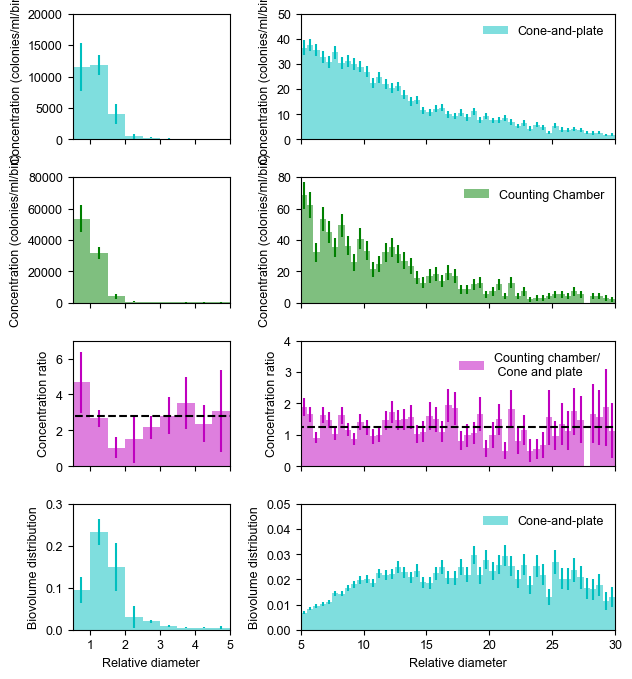

In [57]:
## Detect in features in reference sample
#cali_path = '//iop-s0.science.uva.nl/Jalaal/Yuri/Colony Formation and Breakage Experiments/Concentration Calibration/Cone-and-plate/3500ul-Filtered-col_G009-21-02-23-Sample_3/sample3_1/sample3_1_MMStack_Pos0.ome.tif' # Calibration image - path
#last_frame = import_frames(cali_path,500)

## Import features from cone-and-plate
fea_cone_path = 'C:/Users/Yuri/surfdrive - Yuri Sinzato@surfdrive.surf.nl/Research/PhD/Projects/Project Fragmentation-Aggregation/Aggregation - Breakage Experiments/Cone and Plate Shear Flow/Calibration of concentration/Calibration-MV163-22-2-23/Sample3_cone_and_plate_features_detected/features.csv'
## Impor features from Nikon Ti2
fea_Ti2_4x_path = 'C:/Users/Yuri/surfdrive - Yuri Sinzato@surfdrive.surf.nl/Research/PhD/Projects/Project Fragmentation-Aggregation/Aggregation - Breakage Experiments/Cone and Plate Shear Flow/Calibration of concentration/Calibration-MV163-22-2-23/Sample3_NikonTi2/Results_4x_blur_5.csv'
fea_Ti2_10x_path = 'C:/Users/Yuri/surfdrive - Yuri Sinzato@surfdrive.surf.nl/Research/PhD/Projects/Project Fragmentation-Aggregation/Aggregation - Breakage Experiments/Cone and Plate Shear Flow/Calibration of concentration/Calibration-MV163-22-2-23/Sample3_NikonTi2/Results_10x_noblur.csv'


# ## Calculate distributions
## Plot distributions
cali_distribution=calc_ref_dist()

## Store parameters

In [416]:
# Store the parameters used for this measurement
parameters = pd.DataFrame()  # Initialize parameters dataframe
newline = pd.DataFrame({'a1': a1,
                        'd1': d1,
                        'd_eq1': d_eq1,
                        'v1': v1,
                        'df3': df3,
                        'cons_cali_small': cons_cali_small,
                        'cons_cali_cutoff': cons_cali_cutoff,
                        'cons_cali_large': cons_cali_large,
                        'frame_path': frame_path,
                        'thr_value_large': thr_value_large,
                        'thr_value_small': thr_value_small,
                        'pixel_size': pixel_size,
                        'frame_width': frame_width,
                        'crop_size': crop_size,
                        'frame_area': frame_area,
                        'gap': gap,
                        'single_cell_phi': single_cell_phi,
                        'single_cell_con': single_cell_con,
                        'blur_radius': blur_radius,
                        'cut_off_size': cut_off_size,
                        'Ns': Ns,
                        'N_br': N_br,
                        'h_br': h_br,
                         }, index=[0], )
parameters = pd.concat([parameters, newline], axis=0)
#parameters.to_csv('Temporary Results/parameters.csv')

## Find features

In [417]:
# Find features
#background_image = np.genfromtxt('Temporary Results/background_image.csv', delimiter=',')
#last_frame = import_frames(frame_path,5600)

## Calculate distributions

In [418]:
# Calculate distributions
clear_output()
distribution = calculate_distributions()

#Exit interactive mode,and freeze figures
plt.ioff()

4.462797668176786
4.462797668176786
4.462797668796478
4.462797601497754
4.462796865043399
4.462798000627273
4.462797547011312
4.462796719347631
4.462797694856332
4.462797676985154
4.462797672588336
4.462797667825325
4.4627976681632235
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
4.462797668176786
1481.6134323403444
1481.6134323403444
1481.6134285690382
1481.6134157283627
1481.6134328782925
1481.6127308104828
1481.613463460631
1481.6134330839946
1481.6134328258847
1481.6134324237064
1481.6134323492704
1481.6134323397089
1481.6134323403082
1481.6134323403444
1481.6134323403444
1481.6134323403444
1481.6134323403444
1481.6134323403444
1481.6134323403444
1481.6134323403444
1481.613